## Modeling

Source: https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

### Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Data

Reducing model complexity by dropping three predictors least correlated with Average Speed

In [3]:
df = pd.read_csv("/Users/nicholas.elich/STRAVA_ML/runs_cleaned.csv")
df.drop(["Elevation Low (ft)", "Average Grade", "Hour of Day", "Elevation Loss (ft)"], axis=1, inplace=True)
df.head()

,Max Grade,Average Cadence,Distance (mi),Max Speed (mph),Average Speed (mph),Elevation Gain (ft),Elevation High (ft),Rest Hours
0,7.370569,85.641602,4.996892,11.667214,8.079084,204.800014,394.37619,44.851111
1,18.241413,83.782791,8.098198,17.090331,7.100995,745.661169,951.16188,38.643333
2,7.689279,88.927971,3.996271,10.451713,7.975116,182.882946,394.37619,81.803333
3,6.325908,87.573807,3.101305,10.741350,8.461270,62.667101,385.51750,23.407222
4,4.724410,83.935760,3.095090,10.255405,8.626942,87.799561,384.86131,142.904722


### Train/Test Split

In [4]:
y = df["Average Speed (mph)"]
df.drop(["Average Speed (mph)"], axis=1, inplace=True)
X = df

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=30)

In [6]:
print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("Y Train:", y_train.shape)
print("Y Test:", y_test.shape)

X Train: (173, 7)
X Test: (75, 7)
Y Train: (173,)
Y Test: (75,)


### Standardizing

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, 'scaler.pkl')
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Data Processing and Instantiation

In [8]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values)
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [9]:
batch_size = 20

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size = batch_size, 
                              shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size = batch_size,
                            shuffle=True)

In [10]:
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([20, 7])
y shape: torch.Size([20])


### Initial Model

- Input Layer: 7 Features --> 7 Nodes
- Hidden Layer: Mean of neurons in input and output layers --> 4 Nodes
- Output Layer: Regressor --> 1 Node

In [11]:
model = nn.Sequential(nn.Linear(7, 4),
                      nn.ReLU(),
                      nn.Linear(4, 4),
                      nn.ReLU(),
                      nn.Linear(4, 1))
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
num_epochs = 100
loss_values = []
training_loss = [] #

for epoch in range(num_epochs):
    temp = [] #
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        X = X.float()
        y = y.float()
        
        pred = model(X)
        loss = loss_func(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        temp.append(loss.item()) # 
        loss.backward()
        optimizer.step()
    training_loss.append(sum(temp)/len(temp)) #
print("Training Complete")

Training Complete


### Visualizing Loss

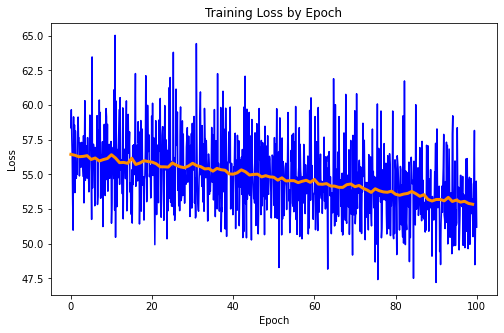

In [13]:
step = np.linspace(0, 100, 900)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values), color="blue")
plt.plot(np.array(training_loss), color="darkorange", linewidth=3)
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Inference/Predictions

In [14]:
model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for X, y in test_dataloader:
        
        X = X.float()
        y = y.float()
        
        outputs = model(X)
        predictions.append(outputs.numpy())
        true_values.append(y.unsqueeze(-1).numpy())

In [15]:
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

In [16]:
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}")

MSE: 53.32062530517578, MAE: 7.269359588623047, RMSE: 7.302097320556641


### Improving the Model

Large training loss indicates opportunity for improvement in the model

- Adding an additional hidden layer and increasing the number of neurons in the layers
- Increasing the learning rate

In [17]:
model = nn.Sequential(nn.Linear(7, 24),
                      nn.ReLU(),
                      nn.Linear(24, 16),
                      nn.ReLU(),
                      nn.Linear(16, 6),
                      nn.ReLU(),
                      nn.Linear(6, 1))
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 100

loss_values = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    
    # TRAINING
    model.train()
    temp_train = []
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        X = X.float()
        y = y.float()
        
        pred = model(X)
        loss = loss_func(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        temp_train.append(loss.item())
        loss.backward()
        optimizer.step()
    training_loss.append(sum(temp_train)/len(temp_train))
    
    # VALIDATION
    model.eval()
    temp_val = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.float()
            y = y.float()

            outputs = model(X)

            loss = loss_func(outputs, y.unsqueeze(-1))
            temp_val.append(loss.item())
        validation_loss.append(sum(temp_val)/len(temp_val))

print("Training Complete")

Training Complete


### Visualizing Loss

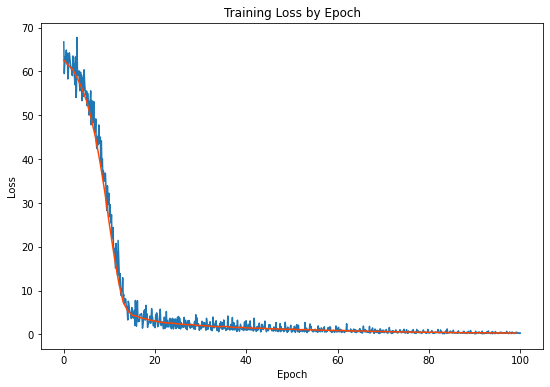

In [19]:
step = np.linspace(0, 100, 900)

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(step, np.array(loss_values))
plt.plot(np.array(training_loss), color="orangered")
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Checking Overfitting

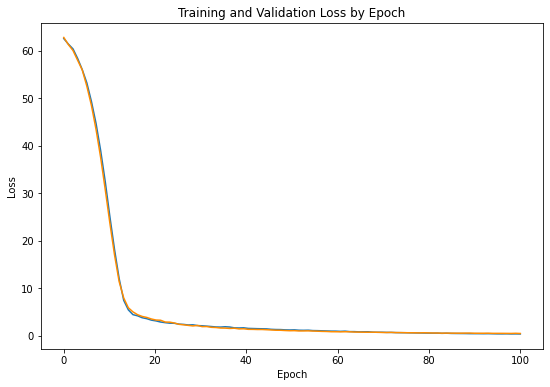

In [20]:
step = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(step, np.array(training_loss))
plt.plot(step, np.array(validation_loss), color="darkorange")
plt.title("Training and Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Initially, the training loss continued to decrease, while the validation loss started to increase which indicated overfitting. The changes below produced the above graph:

- Introduction of additional layer and neurons within the layer
- Increase of learning rate
- Reducing model complexity by dropping predictors

With the changes, the training and validation loss converges as desired and appears to be a good model fit. 

### Model Evaluation

In [21]:
model.eval()

predictions = []
true_values = []
validation_loss = [] #

with torch.no_grad():
    for X, y in test_dataloader:
        
        X = X.float()
        y = y.float()
        
        outputs = model(X)
        predictions.append(outputs.numpy())
        true_values.append(y.unsqueeze(-1).numpy())
        
        loss = loss_func(outputs, y.unsqueeze(-1)) #
        validation_loss.append(loss.item()) #

In [22]:
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

In [23]:
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}")

MSE: 0.4514157474040985, MAE: 0.5132109522819519, RMSE: 0.6718748211860657


All measures of error have decreased

### Saving the Model

In [24]:
torch.save(model, "model_complete.pth")